In [1]:
pip install faiss-cpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.7/30.7 MB 12.5 MB/s eta 0:00:00


In [2]:
pip install pypdf

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.3/302.3 kB 3.6 MB/s eta 0:00:00


In [3]:
import torch
import faiss
import pypdf
import json
import os
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForCausalLM
from sentence_transformers import SentenceTransformer
from huggingface_hub import hf_hub_download

In [4]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/"MA4 semester project"

Mounted at /content/drive
/content/drive/MyDrive/MA4 semester project


In [5]:
import utils
from utils import ChunkLoader, RAGEncoder, retrieve_relevant_docs, read_pdf, get_pdf_chunks, get_all_chunks

In [6]:
MAX_CHUNK_SIZE = 256
OVERLAP = int(0.2*MAX_CHUNK_SIZE)

#GPT2 was released in the year 2019 --> 2020
tokenizer = AutoTokenizer.from_pretrained("openai-community/gpt2")
model = AutoModelForCausalLM.from_pretrained("openai-community/gpt2")
tokenizer.add_special_tokens({'pad_token': '<|pad|>'})
embedding_layer = model.resize_token_embeddings(len(tokenizer))
model.config.pad_token_id = tokenizer.pad_token_id

rag_encoder_model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
rag_encoder_tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/all-MiniLM-L6-v2')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [7]:
#The embedding size for GPT small is 768
print("The vocabulary length for the GPT2 small model is:", len(tokenizer))
print("The number of parameters for the GPT2 small model is:", sum(p.numel() for p in model.parameters()))
print("The max sentence length for this model is {}".format(tokenizer.model_max_length))
print("The beginning of sequence token {} token has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.bos_token_id), tokenizer.bos_token_id))
print("The end of sequence token {} has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.eos_token_id), tokenizer.eos_token_id))
print("The pad token {} has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.pad_token_id), tokenizer.pad_token_id))

The vocabulary length for the GPT2 small model is: 50258
The number of parameters for the GPT2 small model is: 124440576
The max sentence length for this model is 1024
The beginning of sequence token <|endoftext|> token has the id 50256
The end of sequence token <|endoftext|> has the id 50256
The pad token <|pad|> has the id 50257


# Getting the chunks and their corresponding embeddings

In [ ]:
all_chunks = get_all_chunks("./RAG documents/past-2021", tokenizer, MAX_CHUNK_SIZE, OVERLAP)
len(all_chunks)

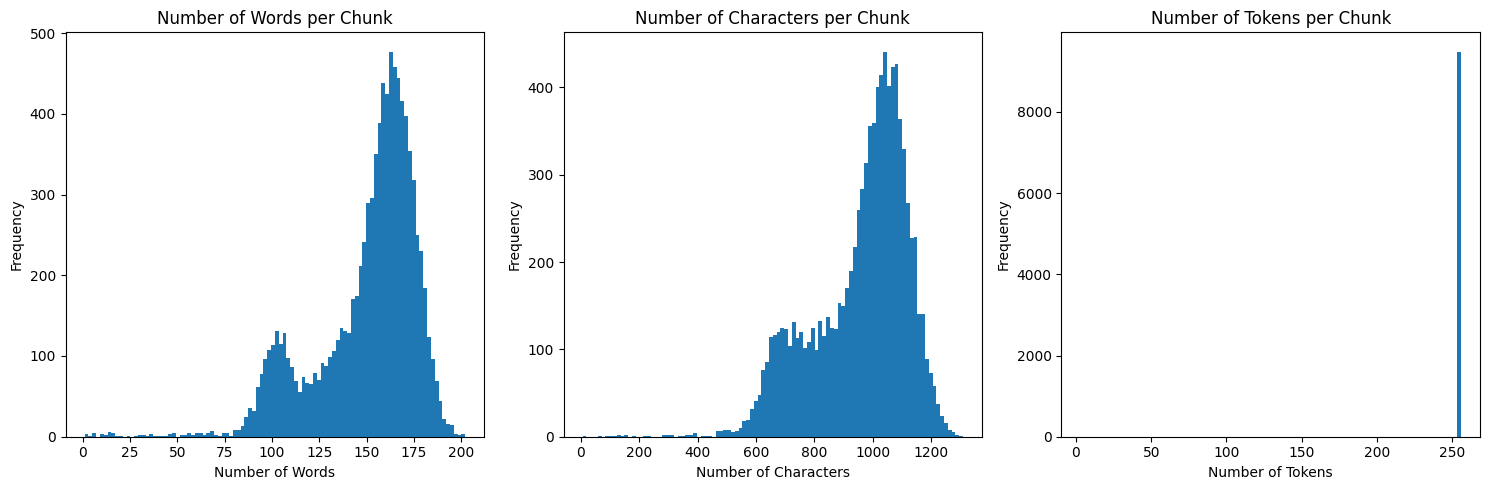

In [ ]:
nb_words = []
nb_chars = []
nb_tokens = []
for chunk in all_chunks:
  nb_words_chunk = len(chunk.split(' '))
  nb_chars_chunk = len(chunk)
  nb_tokens_chunk = len(tokenizer.encode(chunk))
  nb_words.append(nb_words_chunk)
  nb_chars.append(nb_chars_chunk)
  nb_tokens.append(nb_tokens_chunk)


# Disclaimer: this part of the code was generated by chatGPT as it's only used for visualization
# purposes for me to check if everything is as intended and is not part of the coding logic.
fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # Create 3 subplots in one row

# Plot the number of words
axes[0].hist(nb_words, bins=100)
axes[0].set_title('Number of Words per Chunk')
axes[0].set_xlabel('Number of Words')
axes[0].set_ylabel('Frequency')

# Plot the number of characters
axes[1].hist(nb_chars, bins=100)
axes[1].set_title('Number of Characters per Chunk')
axes[1].set_xlabel('Number of Characters')
axes[1].set_ylabel('Frequency')

# Plot the number of tokens
axes[2].hist(nb_tokens, bins=100)
axes[2].set_title('Number of Tokens per Chunk')
axes[2].set_xlabel('Number of Tokens')
axes[2].set_ylabel('Frequency')

plt.tight_layout() # Adjust spacing between subplots
plt.show()

In [ ]:
with open("chunks.jsonl", "w", encoding="utf-8") as f:
    for chunk in all_chunks:
        f.write(json.dumps({"chunk": chunk}) + "\n")

In [ ]:
all_vectors = []
for chunk in tqdm(all_chunks, desc="vectorizing the chunks..."):
  # inputs = tokenizer(chunk, return_tensors='pt')
  # with torch.no_grad():
  #   chunk_embedding = model(**inputs).last_hidden_state[:, 0, :].numpy()
  chunk_embedding = rag_encoder_model.encode(chunk)
  all_vectors.append(chunk_embedding)

all_vectors_array = np.vstack(all_vectors)
np.save('embeddings', all_vectors_array)

# Retrieval Augmented Generation

In [8]:
# Load chunks and their corresponding embeddings
chunks_file = hf_hub_download(repo_id="ziedM/rag_dataset", filename="chunks.jsonl", repo_type="dataset")
chunks = ChunkLoader.load_chunks(chunks_file)
embeddings_file = hf_hub_download(repo_id="ziedM/rag_dataset", filename="embeddings.npy", repo_type="dataset")
chunks_embeddings = np.load(embeddings_file)
faiss.normalize_L2(chunks_embeddings)
print(chunks_embeddings.shape)

# Initialize FAISS index
embedding_dimension = chunks_embeddings.shape[1]
#inner product based similarity score (in our case, same as cosine as vectors are normalised)
index = faiss.IndexFlatIP(embedding_dimension)
index.add(chunks_embeddings)

# Initialize question encoder
question_encoder_model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
question_encoder = RAGEncoder(question_encoder_model, None)
# question_encoder_model = AutoModel.from_pretrained('sentence-transformers/all-MiniLM-L6-v2')
# question_encoder_tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/all-MiniLM-L6-v2')
# question_encoder = QuestionEncoder(question_encoder_model, question_encoder_tokenizer)

chunks.jsonl:   0%|          | 0.00/9.55M [00:00<?, ?B/s]

embeddings.npy:   0%|          | 0.00/14.6M [00:00<?, ?B/s]

(9506, 384)


In [9]:
question = "What will the most impactful deep technologies in the next 5 years be?"
relevant_docs = retrieve_relevant_docs(question, index, chunks, question_encoder, topk=3)
formatted_query = (
    "Using the provided context, answer the given question.\n"
    + "Context: {}\n"
    + " Question: {}\n"
    + " Answer: "
).format(relevant_docs, question)

<class 'numpy.ndarray'>


In [10]:
inputs = tokenizer(formatted_query, return_tensors='pt', truncation=True, max_length=tokenizer.model_max_length)
outputs = model(**inputs)

In [23]:
gen = model.generate(**inputs, pad_token_id=tokenizer.pad_token_id, num_beams=4, do_sample=True, top_p=0.95, max_new_tokens=tokenizer.model_max_length-inputs.input_ids.shape[1])

In [24]:
print(tokenizer.decode(gen[0]))

Using the provided context, answer the given question.
Context: [('.gartner.com/smarterwithgartner/anticipate-and-exploit-future-work-trends/) has moved along quite abit and is about to peak in the near future.”\nUbiquitous Infrastructure\nInfrastructure is no longer in the way of obtaining an organization’s goals. The advent and mass popularity of cloudcomputing and its many variations have enabled an always-on, available and limitless infrastructure computeenvironment.\nThis trend is enabled by the following technologies: 5G (https://www.gartner.com/smarterwithgartner/will-5g-boost-the-adoption-of-smart-living/), Carbon Nanotube (https://www.gartner.com/it-glossary/nanotube/), Deep NeuralNetwork ASICs (https://www.gartner.com/it-glossary/asic-application-specific-integrated-circuit/), NeuromorphicHardware and Quantum Computing (https://www.gartner.com/smarterwithgartner/the-cios-guide-to-quantum-computing/).\nTechnologies supporting ubiquitous infrastructure are on track to reach the